In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Subset
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from torch.utils.data import DataLoader
from torch.functional import F
from torchvision import datasets, transforms
from tqdm import tqdm

SEED = 42
np.random.seed(SEED)

In [2]:
from utils import load_mnist

downsample_factor = 0.99

df_train, df_val, df_test = load_mnist(SEED)

df_train, _ = train_test_split(df_train, test_size=1-downsample_factor, stratify=df_train["label"], random_state=SEED)
# df_val, _ = train_test_split(df_val, test_size=1-downsample_factor, stratify=df_val["label"], random_state=SEED)
# df_test, _ = train_test_split(df_test, test_size=1-downsample_factor, stratify=df_test["label"], random_state=SEED)

In [3]:
X_train, y_train = df_train.drop(columns='label').values, df_train['label'].values
X_val,   y_val   = df_val.drop(columns='label').values,   df_val['label'].values
X_test,  y_test  = df_test.drop(columns='label').values,  df_test['label'].values

In [4]:
# Standardize
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Model

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [6]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_val = encoder.fit_transform(y_val.reshape(-1, 1))

In [7]:
from torch.utils.data import DataLoader, TensorDataset

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to Tensor
    # Random gaussian noise
    transforms.RandomApply([transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x))], p=0.5),
    # Random rotation
    # transforms.RandomApply([transforms.RandomRotation(15)], p=0.5),
    # Random horizontal flip
    transforms.RandomHorizontalFlip(p=0.5),
    # Random vertical flip
    # transforms.RandomVerticalFlip(p=0.5),
    # Random translation
    transforms.RandomApply([transforms.RandomAffine(0, translate=(0.1, 0.1))], p=0.5),
    # Random crop
    transforms.RandomCrop(28, padding=4),
    # Random erasing
    transforms.RandomErasing(p=0.5),
])

x_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 1, 28, 28)
x_val = torch.tensor(X_val, dtype=torch.float32).reshape(-1, 1, 28, 28)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

In [8]:
batch_size = 1600

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Train

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        
        # Define the layers of the residual block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # If input and output channels are different, we need a downsample layer to match dimensions
        self.downsample = downsample

    def forward(self, x):
        identity = x  # Save the input for the skip connection
        
        # First convolution layer with batch normalization and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        
        # Second convolution layer with batch normalization
        out = self.bn2(self.conv2(out))
        
        # Apply the downsample operation if it exists (for matching dimensions)
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # Add the identity (skip connection)
        out += identity
        out = F.relu(out)  # Apply ReLU after the addition
        
        return out

from models import ConvBlock


class NeuralNet(nn.Module):
    def __init__(self, in_channels=1, dropout=0.5):
        super(NeuralNet, self).__init__()

        self.cnn = nn.Sequential(
            ConvBlock(in_channels, 64, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            ConvBlock(64, 128, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
        )
        self.resnet = nn.Sequential(
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
            ResidualBlock(128, 256, stride=2, downsample=nn.Sequential(nn.Conv2d(128, 256, kernel_size=1, stride=2), nn.BatchNorm2d(256))),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 512, stride=2, downsample=nn.Sequential(nn.Conv2d(256, 512, kernel_size=1, stride=2), nn.BatchNorm2d(512))),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
            ResidualBlock(512, 1024, stride=2, downsample=nn.Sequential(nn.Conv2d(512, 1024, kernel_size=1, stride=2), nn.BatchNorm2d(1024))),
        )
        self.mlp = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(dropout//2),
            nn.Linear(256, 10)
        )



    def forward(self, x):
        output = self.cnn(x)

        output = self.resnet(output)
        # print(output.shape)

        output = output.view(output.size(0), -1)
        # print(output.shape)

        output = self.mlp(output)
        
        return output

In [10]:
model = NeuralNet(1, 0.05).to(device)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):.1E}")

Number of parameters: 3.2E+07


In [11]:
from utils import train


initial_lr = 1e-6
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, weight_decay=1e-6, betas=(0.99, 0.999))
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

train_losses, val_losses, lr_evolution = train(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion = nn.CrossEntropyLoss(),
    optimizer = optimizer,
    lr_scheduler = lr_scheduler,
    n_epochs = 150,
    grad_clip = 0.3,
    device = device
)

Progress:  65%|██████▍   | 97/150 [06:51<03:44,  4.24s/it, Train Loss=0.166, Val Loss=0.327]

Early stopping triggered!


Final training loss: 0.16645643055274678
Final validation loss: 0.3268962343533834


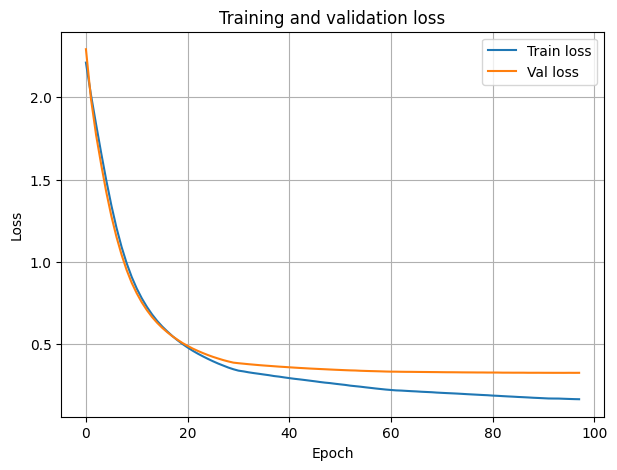

In [12]:
from utils import Plots

Plots.loss_plot(train_losses, val_losses)

In [13]:
# Compute predictions on train and validation set
y_train_pred = np.zeros((len(y_train), 10))
y_val_pred = np.zeros((len(y_val), 10))

model.eval()
for i, (x_batch, y_batch) in enumerate(train_loader):
    x_batch = x_batch.to(device)
    y_train_pred[i * batch_size:(i + 1) * batch_size] = model(x_batch).detach().cpu().numpy()

for i, (x_batch, y_batch) in enumerate(val_loader):
    x_batch = x_batch.to(device)
    y_val_pred[i * batch_size:(i + 1) * batch_size] = model(x_batch).detach().cpu().numpy()

In [14]:
y_train_pred = encoder.inverse_transform(y_train_pred)
y_val_pred = encoder.inverse_transform(y_val_pred)

from sklearn.metrics import accuracy_score

train_acc = accuracy_score(df_train['label'], y_train_pred)
val_acc = accuracy_score(df_val['label'], y_val_pred)

print(f"Train accuracy: {train_acc:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")

Train accuracy: 0.0982
Validation accuracy: 0.8903


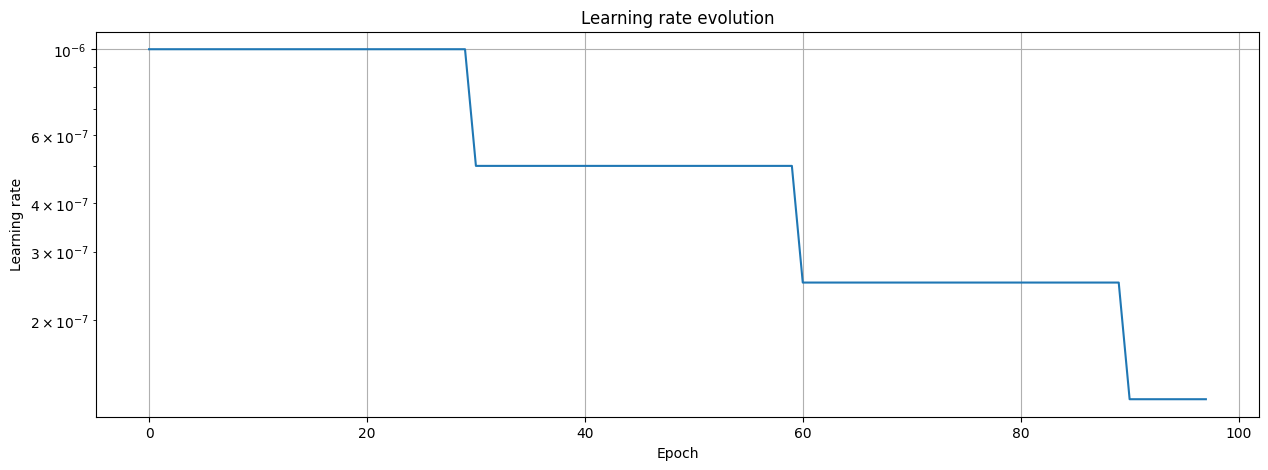

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(lr_evolution)
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning rate')
ax.set_title('Learning rate evolution')
ax.grid(True)
ax.set_yscale('log')
plt.show()